In [1]:
from scw_compare import get_era5_lsm
from percent_mean_change import transform_from_latlon
import matplotlib.pyplot as plt
import geopandas
import pandas as pd
from rasterio import features
from affine import Affine
import glob
import xarray as xr
import numpy as np
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import genextreme
from tqdm import tqdm
import netCDF4 as nc
from ari import drop_duplicates
from scw_compare import rasterize
import warnings
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from dask.diagnostics import ProgressBar
from distributed import Client
import matplotlib as mpl

def drop_duplicates(ds):

        #Drop time duplicates

        a, ind = np.unique(ds.time.values, return_index=True)
        return(ds.isel({"time":ind}))


In [2]:
def load(y1, y2, djf=False, annmax=True):
    '''
        Load ARI-relevant data for BARRA and ERA5, obtained through ECDF and EV analysis in ari.py. Option to load just from 
        Summer data. Option to load in CDF data created using the annual maxima
    '''
    
    path = "/g/data/eg3/ab4502/gev/"
    if annmax:
        annmaxstr="_annmax"
    else:
        annmaxstr=""
    if djf:
        barpa_gev = xr.open_dataset(path+"barpa_erai_access_gev_djf_"+str(y1)+"_2015.nc")
        barpa_cdf = xr.open_dataset(path+"barpa_erai_access_cdf_djf_"+str(y1)+"_2015"+annmaxstr+".nc")
        barpa_cdf_nrm = [ pd.read_csv(path+"barpa_erai_access_cdf_djf_"+str(y1)+"_2015_nrm"+str(i)+annmaxstr+".csv") for i in np.arange(4) ]
        barpa_max = xr.open_dataset(path+"barpa_erai_access_cdf_djf_"+str(y1)+"_2015.nc")
    else:
        barpa_gev = xr.open_dataset(path+"barpa_erai_access_gev_"+str(y1)+"_"+str(y2)+".nc")
        barpa_cdf = xr.open_dataset(path+"barpa_erai_access_cdf_"+str(y1)+"_"+str(y2)+annmaxstr+".nc")
        barpa_cdf_nrm = [ pd.read_csv(path+"barpa_erai_access_cdf_"+str(y1)+"_"+str(y2)+"_nrm"+str(i)+annmaxstr+".csv") for i in np.arange(4) ]
        barpa_max = xr.open_dataset(path+"barpa_erai_access_cdf_"+str(y1)+"_"+str(y2)+".nc")
        
    if djf:
        erai_gev = xr.open_dataset(path+"erai_gev_djf_"+str(y1)+"_"+str(y2)+".nc")
        erai_cdf = xr.open_dataset(path+"erai_cdf_djf_"+str(y1)+"_"+str(y2)+annmaxstr+".nc")
        erai_cdf_nrm = [ pd.read_csv(path+"erai_cdf_djf_"+str(y1)+"_"+str(y2)+"_nrm"+str(i)+annmaxstr+".csv") for i in np.arange(4) ]
        erai_max = xr.open_dataset(path+"erai_cdf_djf_"+str(y1)+"_"+str(y2)+".nc")
    else:
        erai_gev = xr.open_dataset(path+"erai_gev_"+str(y1)+"_"+str(y2)+".nc")
        erai_cdf = xr.open_dataset(path+"erai_cdf_"+str(y1)+"_"+str(y2)+annmaxstr+".nc")
        erai_cdf_nrm = [ pd.read_csv(path+"erai_cdf_"+str(y1)+"_"+str(y2)+"_nrm"+str(i)+annmaxstr+".csv") for i in np.arange(4) ]  
        erai_max = xr.open_dataset(path+"erai_cdf_"+str(y1)+"_"+str(y2)+".nc")
        
    return [barpa_gev, barpa_cdf, barpa_cdf_nrm, barpa_max, erai_gev, erai_cdf, erai_cdf_nrm, erai_max]   

def compute_lmom_gev(da, ari):
    '''
        From an xarray dataarray with variables containing shape, location and scale parameters for a GEV, return the values for a given ari
    '''
    
    n, m = da.c_lmom.shape
    out = np.zeros((n,m))
    c = da.c_lmom.values
    loc = da["loc_lmom"].values
    scale = da.scale_lmom.values
    p = 1 - (1 / ari)
    for i in tqdm(np.arange(n)):
        for j in (np.arange(m)):
                   out[i,j] = genextreme.isf(q=1-p, c=c[i,j], loc=loc[i,j], scale=scale[i,j])
                   
    return out

def compute_wei_lmom(da, ari):
    '''
        From an xarray dataarray with variables containing shape, location and scale parameters for a Weibull EV, return the values for a given ari
    '''
    
    n, m = da["cw_lmom"].shape
    out = np.zeros((n,m))
    c = da["cw_lmom"].values
    loc = da["locw_lmom"].values
    scale = da["scalew_lmom"].values
    p = 1 - (1 / ari)
    for i in tqdm(np.arange(n)):
        for j in (np.arange(m)):
                   out[i,j] = genextreme.isf(q=1-p, c=c[i,j], loc=loc[i,j], scale=scale[i,j])
                   
    return out

def compute_wei(da, ari):
    '''
        From an xarray dataarray with variables containing shape, location and scale parameters for a Weibull EV, return the values for a given ari
    '''
    
    n, m = da["cw"].shape
    out = np.zeros((n,m))
    c = da["cw"].values
    loc = da["locw"].values
    scale = da["scalew"].values
    p = 1 - (1 / ari)
    for i in tqdm(np.arange(n)):
        for j in (np.arange(m)):
                   out[i,j] = genextreme.isf(q=1-p, c=c[i,j], loc=loc[i,j], scale=scale[i,j])
                   
    return out

def compute_gev(da, ari):
    '''
        From an xarray dataarray with variables containing shape, location and scale parameters for a GEV, return the values for a given ari
    '''
    
    n, m = da.c.shape
    out = np.zeros((n,m))
    c = da.c.values
    loc = da["loc"].values
    scale = da.scale.values
    p = 1 - (1 / ari)
    for i in tqdm(np.arange(n)):
        for j in (np.arange(m)):
                   out[i,j] = genextreme.isf(q=1-p, c=c[i,j], loc=loc[i,j], scale=scale[i,j])
                   
    return out

def compute_lmom_gev_nrm(da):
    '''
        From the NRM-maximum annual time series-fitted GEV, compute the ARI
    '''
    T = (np.logspace(-1,3,1000))
    out =  [ genextreme.isf(q=1-(1-(1/T)), c=da.attrs["c_lmom_nrm"][i], loc=da.attrs["loc_lmom_nrm"][i], scale=da.attrs["scale_lmom_nrm"][i]) for i in np.arange(4) ]
    return [out, T]   

def compute_gev_nrm(da):
    '''
        From the NRM-maximum annual time series-fitted GEV, compute the ARI
    '''
    T = (np.logspace(-1,3,1000))
    out =  [ genextreme.isf(q=1-(1-(1/T)), c=da.attrs["nrm_c"][i], loc=da.attrs["nrm_loc"][i], scale=da.attrs["nrm_scale"][i]) for i in np.arange(4) ]
    return [out, T]   

def compute_lmom_wei_nrm(da):
    '''
        From the NRM-maximum annual time series-fitted GEV, compute the ARI
    '''
    T = (np.logspace(-1,3,1000))
    out =  [ genextreme.isf(q=1-(1-(1/T)), c=da.attrs["cw_lmom_nrm"][i], loc=da.attrs["locw_lmom_nrm"][i], scale=da.attrs["scalew_lmom_nrm"][i]) for i in np.arange(4) ]
    return [out, T]   

def compute_wei_nrm(da):
    '''
        From the NRM-maximum annual time series-fitted GEV, compute the ARI
    '''
    T = (np.logspace(-1,3,1000))
    out =  [ genextreme.isf(q=1-(1-(1/T)), c=da.attrs["nrm_cw"][i], loc=da.attrs["nrm_locw"][i], scale=da.attrs["nrm_scalew"][i]) for i in np.arange(4) ]
    return [out, T]   

def plot_borders(nrm_da):
    xr.plot.contour(xr.where(nrm_da["aus"]==1, 1, 0), levels=[0.5,1.5], colors="k", add_labels=False)
    #[xr.plot.contour(xr.where((nrm_da==i) & (~(nrm_da["aus"].isnull())), 1, 0), levels=[0.5,1.5], colors="k", add_labels=False) for i in [0,1,2,3]]


In [3]:
#LOAD DATA

ari=10
cdf_ari="ari10"
djf=False
annmax=True
barpa_gev, barpa_cdf, barpa_cdf_nrm, barpa_max, erai_gev, erai_cdf, erai_cdf_nrm, erai_max = \
        load(1990, 2015, djf)

barpa_lmom_ari = compute_lmom_gev(barpa_gev, ari)
barpa_ari_lmom_nrm, T = compute_lmom_gev_nrm(barpa_gev)

erai_lmom_ari = compute_lmom_gev(erai_gev, ari)
erai_ari_lmom_nrm, T = compute_lmom_gev_nrm(erai_gev)


100%|██████████| 46/46 [00:00<00:00, 101.36it/s]


In [4]:
#Load AWS station information and data, plot stations

names = ["id", "stn_no", "district", "stn_name", "1", "2", "lat", "lon", "3", "4", "5", "6", "7", "8", \
"9", "10", "11", "12", "13", "14", "15", "16"]	
df = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/obs/aws/daily_aus_full/DC02D_StnDet_999999999643799.txt",\
names=names, header=0)
renames = {'ALICE SPRINGS AIRPORT                   ':"Alice Springs",\
'GILES METEOROLOGICAL OFFICE             ':"Giles",\
'COBAR MO                                ':"Cobar",\
'AMBERLEY AMO                            ':"Amberley",\
'SYDNEY AIRPORT AMO                      ':"Sydney",\
'MELBOURNE AIRPORT                       ':"Melbourne",\
'MACKAY M.O                              ':"Mackay",\
'WEIPA AERO                              ':"Weipa",\
'MOUNT ISA AERO                          ':"Mount Isa",\
'ESPERANCE                               ':"Esperance",\
'ADELAIDE AIRPORT                        ':"Adelaide",\
'CHARLEVILLE AERO                        ':"Charleville",\
'CEDUNA AMO                              ':"Ceduna",\
'OAKEY AERO                              ':"Oakey",\
'WOOMERA AERODROME                       ':"Woomera",\
'TENNANT CREEK AIRPORT                   ':"Tennant Creek",\
'GOVE AIRPORT                            ':"Gove",\
'COFFS HARBOUR MO                        ':"Coffs Harbour",\
'MEEKATHARRA AIRPORT                     ':"Meekatharra",\
'HALLS CREEK METEOROLOGICAL OFFICE       ':"Halls Creek",\
'ROCKHAMPTON AERO                        ':"Rockhampton",\
'MOUNT GAMBIER AERO                      ':"Mount Gambier",\
'PERTH AIRPORT                           ':"Perth",\
'WILLIAMTOWN RAAF                        ':"Williamtown",\
'CARNARVON AIRPORT                       ':"Carnarvon",\
'KALGOORLIE-BOULDER AIRPORT              ':"Kalgoorlie",\
'DARWIN AIRPORT                          ':"Darwin",\
'CAIRNS AERO                             ':"Cairns",\
'MILDURA AIRPORT                         ':"Mildura",\
'WAGGA WAGGA AMO                         ':"Wagga Wagga",\
'BROOME AIRPORT                          ':"Broome",\
'EAST SALE                               ':"East Sale",\
'TOWNSVILLE AERO                         ':"Townsville",\
'HOBART (ELLERSLIE ROAD)                 ':"Hobart",\
'PORT HEDLAND AIRPORT                    ':"Port Hedland"}
df = df.replace({"stn_name":renames})
points = [(df.lon.iloc[i], df.lat.iloc[i]) for i in np.arange(df.shape[0])]
temp = xr.open_dataset("/g/data/eg3/ab4502/ExtremeWind/aus/regrid_1.5/ERA5__mean_lr36_historical_1979_2005.nc")
f = geopandas.read_file("/home/548/ab4502/NRM_super_clusters/NRM_super_clusters.shp")
f2 = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))
shapes = [(shape, n) for n, shape in enumerate(f.geometry)]
nrm_da = rasterize(shapes, {"lon":temp.lon,"lat":temp.lat})
nrm_da["aus"] = rasterize([f2.loc[f2.name=="Australia"].geometry.values[0]], {"lon":temp.lon,"lat":temp.lat})
names = ["record_id","stn_no","stn_name","locality", "state","lat","lon","height","date_str",\
                "wind_gust","quality","wind_dir", "wind_dir_quality", "max_gust_str_lt", \
                "max_gust_time_quality", "eof"]
data_types = dict(record_id=str, stn_no=int, stn_name=str, locality=str, state=str, lat=float, lon=float,\
                                height=str, date_str=str, wind_gust=float, quality=str, \
                                wind_dir=str, wind_dir_quality=str, max_gust_str_lt=str,\
                                max_gust_time_quality=str,\
                                eof=str)
f = "/g/data/eg3/ab4502/ExtremeWind/obs/aws/daily_aus_full/DC02D_Data_999999999720188.txt"
obs = pd.read_csv(f, names=names, dtype=data_types, na_values={"wind_gust":'     ', "max_gust_str_lt":"    "})
obs = obs.replace({"stn_name":renames})
obs["wind_dir"] = obs["wind_dir"].str.strip()
obs["wind_dir"] = pd.to_numeric(obs.wind_dir, errors="coerce")
obs["stn_name"] = obs["stn_name"].str.strip()
obs["year"] = obs.date_str.str.slice(6,10).astype("int")
obs["month"] = obs.date_str.str.slice(3,5).astype("int")
obs["day_lt"] = obs.date_str.str.slice(0,2).astype("int")
obs["daily_date_lt"] = pd.to_datetime({"year":obs["year"],"month":obs["month"],"day":obs["day_lt"]})


In [5]:
#Plot ARI comparison between BARRA, BARPA and station data

def compare_with_obs(loc_name, leg=False):

    stn_lon = df[df.stn_name==loc_name]["lon"]
    stn_lat = df[df.stn_name==loc_name]["lat"]

    #BARPA
    topog = xr.open_dataset("/g/data/du7/barpa/trials/BARPA-EASTAUS_12km/static/topog-BARPA-EASTAUS_12km.nc")["topog"].interp({"latitude":barpa_gev.lat, "longitude":barpa_gev.lon}, "nearest")
    lsm_barp = ((topog.values) > 0) * 1
    a,b = np.meshgrid(barpa_gev.lon, barpa_gev.lat)
    a[lsm_barp==0] = np.nan
    b[lsm_barp==0] = np.nan
    dist = np.sqrt(np.square(a-stn_lon.values[0]) + \
                        np.square(b-stn_lat.values[0]))
    temp_lat,temp_lon = np.unravel_index(np.nanargmin(dist),dist.shape)

    c = barpa_gev["c"].isel({"lat":temp_lat, "lon":temp_lon})
    loc = barpa_gev["loc"].isel({"lat":temp_lat, "lon":temp_lon})
    scale = barpa_gev["scale"].isel({"lat":temp_lat, "lon":temp_lon})
    p = np.linspace(0,1,10000)
    barp_T = 1/(1-p)
    barp_x = np.squeeze(genextreme.isf(q=1-p, c=c, loc=loc, scale=scale))
    barp_x_raw = np.sort(xr.open_dataset("/g/data/eg3/ab4502/gev/barpa_erai_annmax_annual_1990_2015.nc")["da"].isel({"lat":temp_lat, "lon":temp_lon}).values)
    barp_T_raw = (1 / (1 - ECDF(barp_x_raw).y))

    #ERAI
    topog = xr.open_dataset("/g/data/eg3/ab4502/erai_lsm.nc")["lsm"].interp({"latitude":erai_gev.lat, "longitude":erai_gev.lon}, "nearest")
    lsm_erai = (np.squeeze(topog.values) > 0) * 1
    a,b = np.meshgrid(erai_gev.lon, erai_gev.lat)
    a[lsm_erai==0] = np.nan
    b[lsm_erai==0] = np.nan
    dist = np.sqrt(np.square(a-stn_lon.values[0]) + \
                        np.square(b-stn_lat.values[0]))
    temp_lat,temp_lon = np.unravel_index(np.nanargmin(dist),dist.shape)

    c = erai_gev["c"].isel({"lat":temp_lat, "lon":temp_lon})
    loc = erai_gev["loc"].isel({"lat":temp_lat, "lon":temp_lon})
    scale = erai_gev["scale"].isel({"lat":temp_lat, "lon":temp_lon})
    p = np.linspace(0,1,10000)
    erai_T = 1/(1-p)
    erai_x = np.squeeze(genextreme.isf(q=1-p, c=c, loc=loc, scale=scale))
    erai_x_raw = np.sort(xr.open_dataset("/g/data/eg3/ab4502/gev/erai_annmax_annual_1990_2015.nc")["da"].isel({"lat":temp_lat, "lon":temp_lon}).values)
    erai_T_raw = (1 / (1 - ECDF(erai_x_raw).y))

    #OBS
    obs_x = np.sort(obs[obs.stn_name==loc_name].query("year>=1990").query("year<=2015")[["daily_date_lt", "wind_gust"]].iloc[:-1].resample("1Y", on="daily_date_lt").max()["wind_gust"].values)
    obs_T = (1 / (1 - ECDF(obs_x).y))
    c,loc,scale = genextreme.fit(obs_x)
    p = np.linspace(0,1,10000)
    obs_fit_x = genextreme.isf(q=1-p, c=c, loc=loc, scale=scale)
    obs_fit_T = 1/(1-p)

    plt.plot(barp_T, barp_x, label="BARPA-R", color="k")
    plt.plot(barp_T_raw[:-1], barp_x_raw, marker="o", linestyle="none", color="k", mfc="none")
    plt.plot(erai_T, erai_x, label="ERA-Interim", color="tab:blue")
    plt.plot(erai_T_raw[:-1], erai_x_raw, marker="x", linestyle="none", color="tab:blue")

    plt.plot(obs_fit_T, obs_fit_x, label="Observed", color="tab:orange")
    plt.plot(obs_T[:-1], obs_x, marker="x", color="tab:orange", linestyle="none")
    plt.ylim([10,50])
    plt.xlim([1,200])
    plt.xscale("log")
    #plt.title(loc_name, size=16)
    if leg:
        plt.legend(fontsize=15)
    ax=plt.gca()
    ax.tick_params(axis='both', which='major', labelsize=15)
    plt.xlabel("Recurrence interval (years)", size=15)
    plt.ylabel("Annual maximum \n10 m wind gust (m/s)", size=15)


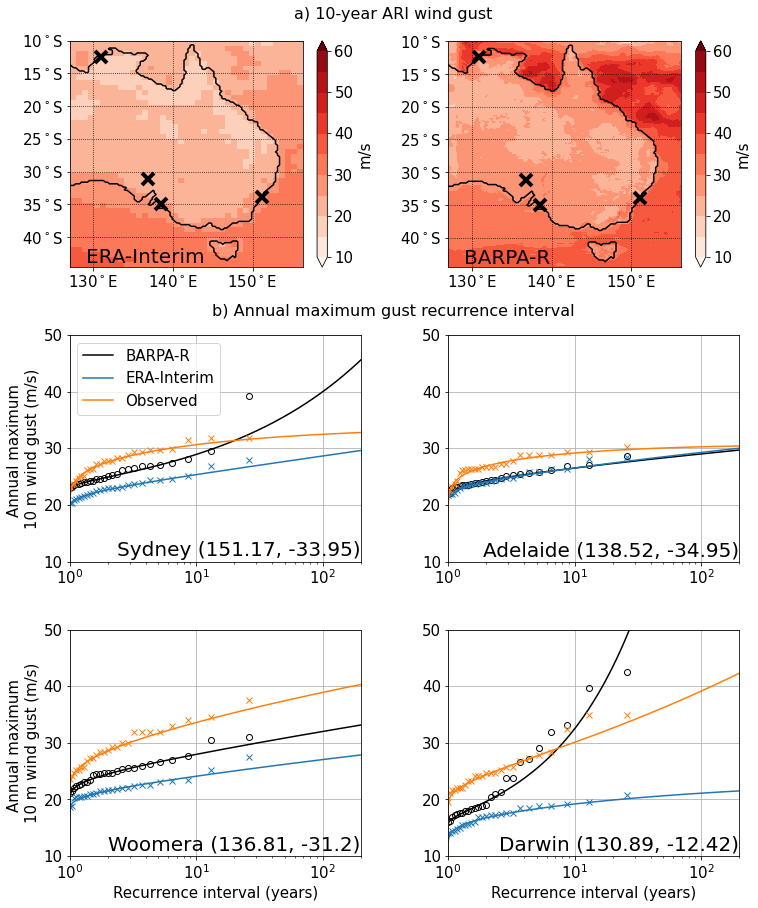

In [6]:
#PLOTTING - Spatial map of 10-year ARI and max wind gust

mpl.rcParams.update({'font.size': 15})

era5_range = [10,60]
barra_range = [10,60]
cmap = plt.get_cmap("Reds")
levels = 11
rows=5
cols=8

temp = xr.open_dataset("/g/data/eg3/ab4502/ExtremeWind/aus/regrid_1.5/ERA5__mean_lr36_historical_1979_2005.nc")
f1 = geopandas.read_file("/home/548/ab4502/NRM_super_clusters/NRM_super_clusters.shp")
f2 = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))
shapes = [(shape, n) for n, shape in enumerate(f1.geometry)]
nrm_da = rasterize(shapes, {"lon":temp.lon,"lat":temp.lat})
nrm_da["aus"] = rasterize([f2.loc[f2.name=="Australia"].geometry.values[0]], {"lon":temp.lon,"lat":temp.lat})

fig=plt.figure(figsize=([12,15]))
fig.text(0.5,0.9,"a) 10-year ARI wind gust", size=16, ha="center")
fig.text(0.5,0.625,"b) Annual maximum gust recurrence interval", size=16, ha="center")


#BARPA GEV LMOM
plt.subplot(3,2,2)
plt.text(129,-44,"BARPA-R",size=20)
xr.DataArray(data=np.where(barpa_gev.lmom_fail==0, barpa_lmom_ari, np.nan), coords=(barpa_gev.lat, barpa_gev.lon)).plot(vmin=barra_range[0], vmax=barra_range[1], levels=levels, cmap=cmap, extend="both", cbar_kwargs={"label":"m/s"})
plot_borders(nrm_da)
plt.plot([136.8054, 151.1731, 138.5196, 130.8925], [-31.1558, -33.9465, -34.9524, -12.4239 ], marker="x", ms=12, color="k", ls="none", mew=4)
plt.gca().set_ylabel(""); plt.gca().set_xlabel("")
plt.gca().grid(linestyle=":", color="k")
plt.xticks([130,140,150],["130$^\circ$E","140$^\circ$E","150$^\circ$E"])
plt.yticks([-10,-15,-20,-25,-30,-35,-40],["10$^\circ$S","15$^\circ$S","20$^\circ$S","25$^\circ$S","30$^\circ$S","35$^\circ$S","40$^\circ$S"])

#ERAI GEV LMOM
plt.subplot(3,2,1)
plt.text(129,-44,"ERA-Interim",size=20)
xr.DataArray(data=np.where(erai_gev.lmom_fail==0, erai_lmom_ari, np.nan), coords=(erai_gev.lat, erai_gev.lon)).plot(xlim = [barpa_gev.lon.min(), barpa_gev.lon.max()], vmin=barra_range[0], vmax=barra_range[1], levels=levels, cmap=cmap, extend="both", cbar_kwargs={"label":"m/s"})
plot_borders(nrm_da)
plt.plot([136.8054, 151.1731, 138.5196, 130.8925], [-31.1558, -33.9465, -34.9524, -12.4239 ], marker="x", ms=12, color="k", ls="none", mew=4)
plt.gca().set_ylabel(""); plt.gca().set_xlabel("")
plt.gca().grid(linestyle=":", color="k")
plt.xticks([130,140,150],["130$^\circ$E","140$^\circ$E","150$^\circ$E"])
plt.yticks([-10,-15,-20,-25,-30,-35,-40],["10$^\circ$S","15$^\circ$S","20$^\circ$S","25$^\circ$S","30$^\circ$S","35$^\circ$S","40$^\circ$S"])

warnings.simplefilter("ignore")
plt.subplot(3,2,3);compare_with_obs("Sydney",leg=True);plt.xlabel("");plt.gca().grid();plt.text(200,11,"Sydney (151.17, -33.95)",size=20, ha="right")
plt.subplot(3,2,4);compare_with_obs("Adelaide");plt.xlabel("");plt.gca().grid();plt.text(200,11,"Adelaide (138.52, -34.95)",size=20, ha="right");plt.ylabel("")
plt.subplot(3,2,5);compare_with_obs("Woomera");plt.gca().grid();plt.text(200,11,"Woomera (136.81, -31.2)",size=20, ha="right")
plt.subplot(3,2,6);compare_with_obs("Darwin");plt.gca().grid();plt.text(200,11,"Darwin (130.89, -12.42)",size=20, ha="right");plt.ylabel("")
plt.subplots_adjust(hspace=0.3, wspace=0.3)

plt.subplots_adjust()
plt.savefig("/g/data/eg3/ab4502/figs/barpa/erai_compare_wg.png", bbox_inches="tight")

In [7]:
def load(v):
    f = xr.open_mfdataset("/g/data/eg3/ab4502/ExtremeWind/aus/threshold_data/barpa_erai_"+v+"_6hr_mean.nc", combine="by_coords")
    e = xr.open_mfdataset("/g/data/eg3/ab4502/ExtremeWind/aus/threshold_data/era5_"+v+"_6hr_mean.nc", combine="by_coords")
    ei = xr.open_mfdataset("/g/data/eg3/ab4502/ExtremeWind/aus/threshold_data/erai_"+v+"_6hr_mean.nc", combine="by_coords")
    return [f,e,ei]

f, e, ei = load("mucape*s06")

#Load AWS data
stn_map = {14015:"Darwin",66037:"Sydney",16001:"Woomera",23034:"Adelaide"}
obs2 = pd.read_pickle("/g/data/eg3/ab4502/ExtremeWind/points/UA_wrfpython.pkl")
obs2["stn_name"] = obs2["stn_id"].map(stn_map)
obs2["mucape*s06"] = obs2["mu_cape"] * np.power(obs2["s06"],1.67)
barpa = pd.read_pickle("/g/data/eg3/ab4502/ExtremeWind/points/barpa_erai_2005_2015.pkl").rename(columns={"loc_id":"stn_name"})
barpa = barpa[np.in1d(barpa.stn_name,["Adelaide","Darwin","Sydney","Woomera"])]
erai = pd.read_pickle("/g/data/eg3/ab4502/ExtremeWind/points/erai_2005_2015.pkl").rename(columns={"loc_id":"stn_name"})
erai = erai[np.in1d(erai.stn_name,["Adelaide","Darwin","Sydney","Woomera"])]
barpa_cape = barpa.set_index(["time","stn_name"])["mucape*s06"].rename("barpa")
erai_cape = erai.set_index(["time","stn_name"])["mucape*s06"].rename("erai")
obs_cape = obs2.set_index(["stn_name"], append=True)["mucape*s06"].rename("obs")
cape = pd.concat([barpa_cape, erai_cape, obs_cape], names=["barpa","obs"], axis=1).dropna()
########



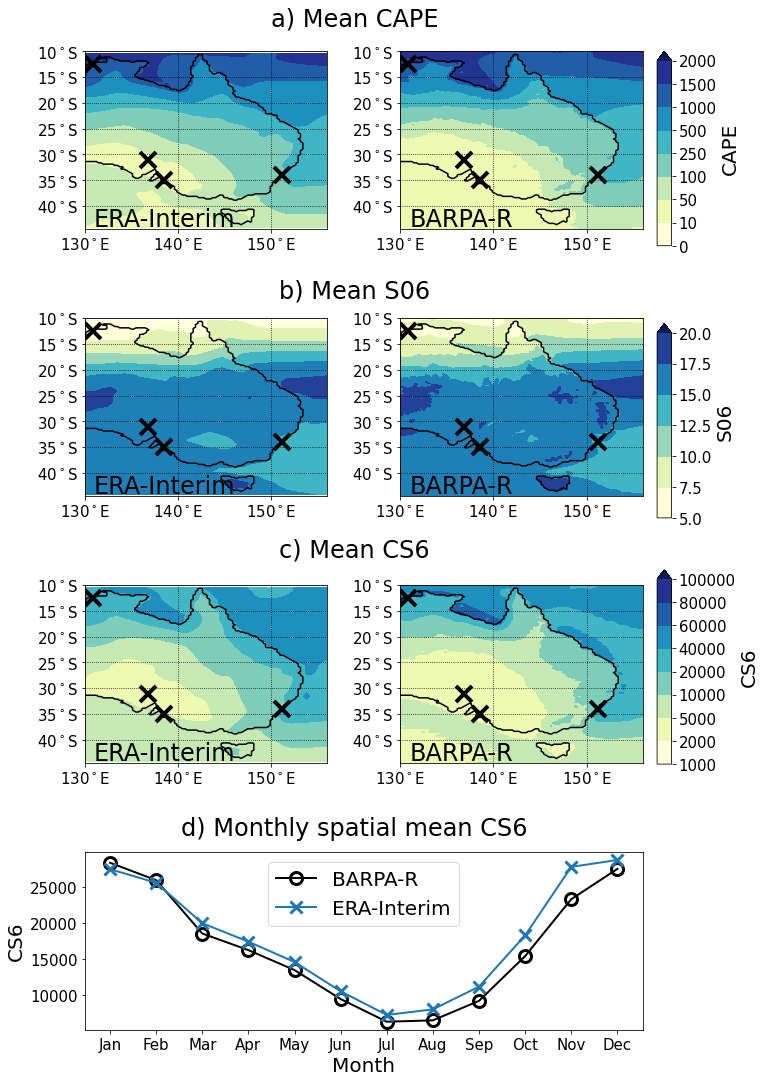

In [8]:
fig=plt.figure(figsize=([10,18]))
start_lat = -44; end_lat = -10; start_lon = 130; end_lon = 156

mpl.rcParams.update({'font.size': 15})

#MUCAPE
f, e, ei = load("mu_cape")
levs=[0,10,50,100,250,500,1000,1500,2000]
t=slice("1990-01-01 00:00", "2015-12-31 18:00"); v="mu_cape"
plt.subplot2grid((4,2), (0,0), rowspan=1, colspan=1)
fig.text(0.5,0.9,"a) Mean CAPE", size=24, ha="center")
c=xr.plot.contourf(ei.sel({"time":t})[v].mean("time"),levels=levs, add_colorbar=False, add_labels=False, cmap=plt.get_cmap("YlGnBu"), xlim=[start_lon,end_lon], extend="max")
plt.plot([136.8054, 151.1731, 138.5196, 130.8925], [-31.1558, -33.9465, -34.9524, -12.4239 ], marker="x", ms=16, color="k", ls="none", mew=4)
plot_borders(nrm_da)
plt.gca().grid(linestyle=":", color="k")
plt.text(131,-44,"ERA-Interim",size=24)
plt.xticks([130,140,150],["130$^\circ$E","140$^\circ$E","150$^\circ$E"])
plt.yticks([-10,-15,-20,-25,-30,-35,-40],["10$^\circ$S","15$^\circ$S","20$^\circ$S","25$^\circ$S","30$^\circ$S","35$^\circ$S","40$^\circ$S"])

plt.subplot2grid((4,2), (0,1), rowspan=1, colspan=1)
plt.text(131,-44,"BARPA-R",size=24)
c=xr.plot.contourf(f.sel({"time":t})[v].mean("time"),levels=levs, add_colorbar=False, add_labels=False, cmap=plt.get_cmap("YlGnBu"), xlim=[start_lon,end_lon], extend="max")
plt.plot([136.8054, 151.1731, 138.5196, 130.8925], [-31.1558, -33.9465, -34.9524, -12.4239 ], marker="x", ms=16, color="k", ls="none", mew=4)
plot_borders(nrm_da)
plt.xticks([130,140,150],["130$^\circ$E","140$^\circ$E","150$^\circ$E"])
plt.yticks([-10,-15,-20,-25,-30,-35,-40],["10$^\circ$S","15$^\circ$S","20$^\circ$S","25$^\circ$S","30$^\circ$S","35$^\circ$S","40$^\circ$S"])
plt.gca().grid(linestyle=":", color="k")
cax=plt.axes([0.92,0.73,0.02,0.15])
cb=plt.colorbar(c,cax=cax,orientation="vertical")
cb.set_label("CAPE", size=20)

#S06
f, e, ei = load("s06")
levs=np.arange(5,22.5,2.5)
t=slice("1990-01-01 00:00", "2015-12-31 18:00"); v="s06"
plt.subplot2grid((4,2), (1,0), rowspan=1, colspan=1)
fig.text(0.5,0.69,"b) Mean S06", size=24, ha="center")
c=xr.plot.contourf(ei.sel({"time":t})[v].mean("time"),levels=levs, add_colorbar=False, add_labels=False, cmap=plt.get_cmap("YlGnBu"), xlim=[start_lon,end_lon], extend="max")
plt.plot([136.8054, 151.1731, 138.5196, 130.8925], [-31.1558, -33.9465, -34.9524, -12.4239 ], marker="x", ms=16, color="k", ls="none", mew=4)
plot_borders(nrm_da)
plt.gca().grid(linestyle=":", color="k")
plt.text(131,-44,"ERA-Interim",size=24)
plt.xticks([130,140,150],["130$^\circ$E","140$^\circ$E","150$^\circ$E"])
plt.yticks([-10,-15,-20,-25,-30,-35,-40],["10$^\circ$S","15$^\circ$S","20$^\circ$S","25$^\circ$S","30$^\circ$S","35$^\circ$S","40$^\circ$S"])

plt.subplot2grid((4,2), (1,1), rowspan=1, colspan=1)
plt.text(131,-44,"BARPA-R",size=24)
c=xr.plot.contourf(f.sel({"time":t})[v].mean("time"),levels=levs, add_colorbar=False, add_labels=False, cmap=plt.get_cmap("YlGnBu"), xlim=[start_lon,end_lon], extend="max")
plt.plot([136.8054, 151.1731, 138.5196, 130.8925], [-31.1558, -33.9465, -34.9524, -12.4239 ], marker="x", ms=16, color="k", ls="none", mew=4)
plot_borders(nrm_da)
plt.xticks([130,140,150],["130$^\circ$E","140$^\circ$E","150$^\circ$E"])
plt.yticks([-10,-15,-20,-25,-30,-35,-40],["10$^\circ$S","15$^\circ$S","20$^\circ$S","25$^\circ$S","30$^\circ$S","35$^\circ$S","40$^\circ$S"])
plt.gca().grid(linestyle=":", color="k")
cax=plt.axes([0.92,0.52,0.02,0.15])
cb=plt.colorbar(c,cax=cax,orientation="vertical")
cb.set_label("S06", size=20)

#CS6
f, e, ei = load("mucape*s06")
levs=[1000,2000,5000,10000,20000,40000,60000,80000,100000]
vmin=1000; vmax=100000; t=slice("1990-01-01 00:00", "2015-12-31 18:00"); v="mucape*s06"
plt.subplot2grid((4,2), (2,0), rowspan=1, colspan=1)
fig.text(0.5,0.49,"c) Mean CS6", size=24, ha="center")
c=xr.plot.contourf(ei.sel({"time":t})[v].mean("time"),levels=levs, add_colorbar=False, add_labels=False, cmap=plt.get_cmap("YlGnBu"), xlim=[start_lon,end_lon], extend="max")
plt.plot([136.8054, 151.1731, 138.5196, 130.8925], [-31.1558, -33.9465, -34.9524, -12.4239 ], marker="x", ms=16, color="k", ls="none", mew=4)
plot_borders(nrm_da)
plt.gca().grid(linestyle=":", color="k")
plt.text(131,-44,"ERA-Interim",size=24)
plt.xticks([130,140,150],["130$^\circ$E","140$^\circ$E","150$^\circ$E"])
plt.yticks([-10,-15,-20,-25,-30,-35,-40],["10$^\circ$S","15$^\circ$S","20$^\circ$S","25$^\circ$S","30$^\circ$S","35$^\circ$S","40$^\circ$S"])

plt.subplot2grid((4,2), (2,1), rowspan=1, colspan=1)
plt.text(131,-44,"BARPA-R",size=24)
c=xr.plot.contourf(f.sel({"time":t})[v].mean("time"),levels=levs, add_colorbar=False, add_labels=False, cmap=plt.get_cmap("YlGnBu"), xlim=[start_lon,end_lon], extend="max")
plt.plot([136.8054, 151.1731, 138.5196, 130.8925], [-31.1558, -33.9465, -34.9524, -12.4239 ], marker="x", ms=16, color="k", ls="none", mew=4)
plot_borders(nrm_da)
plt.xticks([130,140,150],["130$^\circ$E","140$^\circ$E","150$^\circ$E"])
plt.yticks([-10,-15,-20,-25,-30,-35,-40],["10$^\circ$S","15$^\circ$S","20$^\circ$S","25$^\circ$S","30$^\circ$S","35$^\circ$S","40$^\circ$S"])
plt.gca().grid(linestyle=":", color="k")
cax=plt.axes([0.92,0.33,0.02,0.15])
cb=plt.colorbar(c,cax=cax,orientation="vertical")
cb.set_label("CS6", size=20)

#Monthly dist
plt.subplot2grid((4,2), (3,0), rowspan=1, colspan=2)
f[v].sel({"time":t}).groupby("time.month").mean(dim=xr.ALL_DIMS).plot(label="BARPA-R", marker="o", color="k", mfc="none",ms=12,mew=3,lw=2)    
ei[v].sel({"time":t}).interp({"lat":f.lat, "lon":f.lon}).groupby("time.month").mean(dim=xr.ALL_DIMS).plot(label="ERA-Interim", marker="x", color="tab:blue", ms=12, mew=3,lw=2)  
plt.legend(fontsize=20)
plt.ylabel("CS6", size=20)
plt.xlabel("Month", size=20)
plt.gca().set_xticks(np.arange(1,13))
plt.gca().set_xticklabels(["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"])
fig.text(0.5,0.275,"d) Monthly spatial mean CS6", ha="center", size=24)

plt.subplots_adjust(hspace=0.5,wspace=0.3)

plt.savefig("/g/data/eg3/ab4502/figs/barpa/erai_compare_cs6.png", bbox_inches="tight")

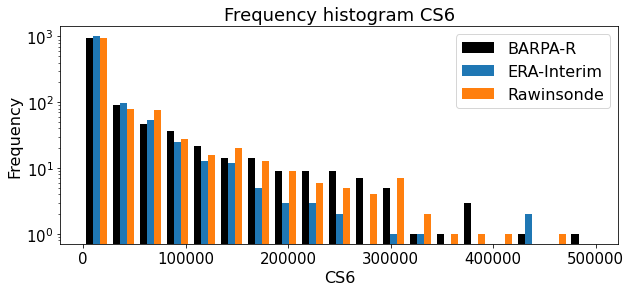

In [9]:
plt.figure(figsize=[10,4])
mpl.rcParams.update({'font.size': 15})

plt.title("Frequency histogram CS6")
plt.hist(np.array(cape), bins=np.linspace(0,500000,20), color=["k","tab:blue","tab:orange"], label=["BARPA-R","ERA-Interim","Rawinsonde"]); plt.yscale("log")
plt.legend(fontsize=16)
plt.ylabel("Frequency",size=16)
plt.xlabel("CS6",size=16)

plt.subplots_adjust(hspace=0.4)
plt.savefig("/g/data/eg3/ab4502/figs/barpa/obs_compare_cs6.png", bbox_inches="tight")

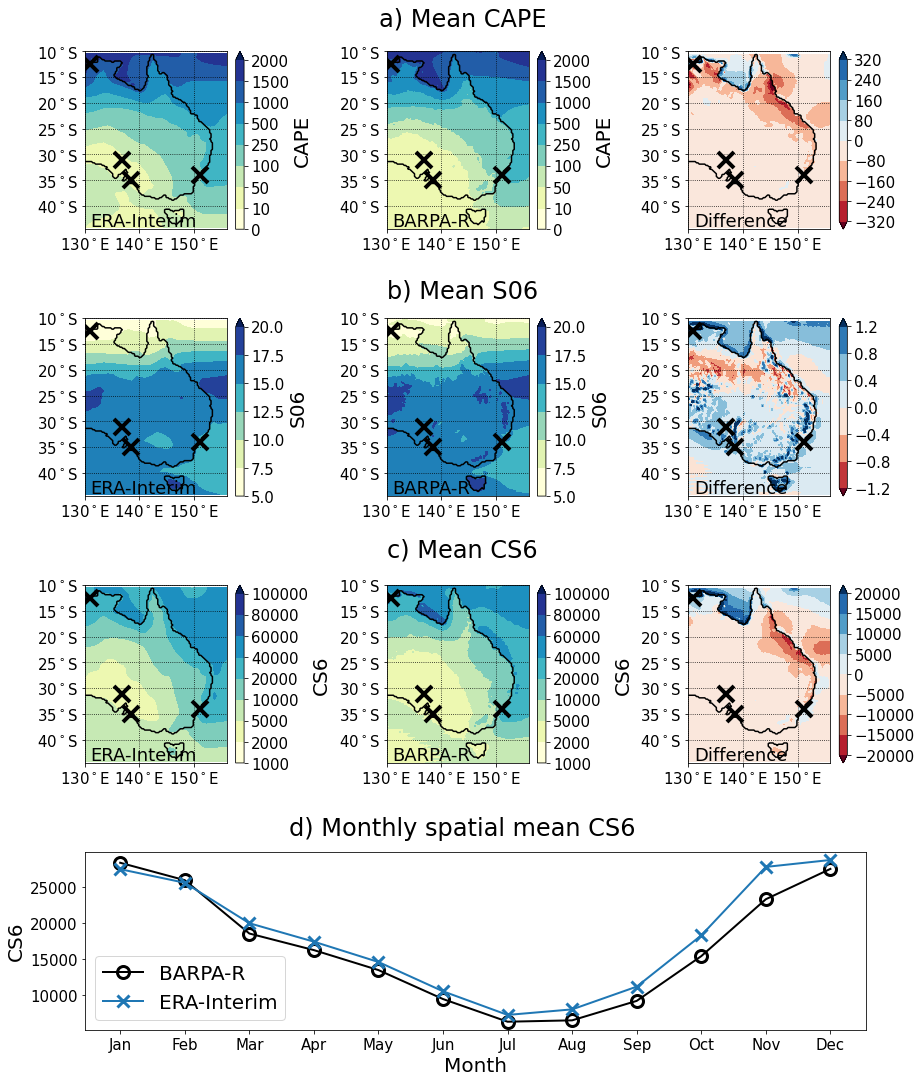

In [10]:
fig=plt.figure(figsize=([14,18]))
start_lat = -44; end_lat = -10; start_lon = 130; end_lon = 156

mpl.rcParams.update({'font.size': 15})
lab_size=18

#MUCAPE
f, e, ei = load("mu_cape")
levs=[0,10,50,100,250,500,1000,1500,2000]
t=slice("1990-01-01 00:00", "2015-12-31 18:00"); v="mu_cape"
plt.subplot2grid((4,3), (0,0), rowspan=1, colspan=1)
fig.text(0.5,0.9,"a) Mean CAPE", size=24, ha="center")
c=xr.plot.contourf(ei.sel({"time":t})[v].mean("time"),levels=levs, add_colorbar=False, add_labels=False, cmap=plt.get_cmap("YlGnBu"), xlim=[start_lon,end_lon], extend="max")
plt.plot([136.8054, 151.1731, 138.5196, 130.8925], [-31.1558, -33.9465, -34.9524, -12.4239 ], marker="x", ms=16, color="k", ls="none", mew=4)
plot_borders(nrm_da)
plt.gca().grid(linestyle=":", color="k")
plt.text(131,-44,"ERA-Interim",size=lab_size)
plt.xticks([130,140,150],["130$^\circ$E","140$^\circ$E","150$^\circ$E"])
plt.yticks([-10,-15,-20,-25,-30,-35,-40],["10$^\circ$S","15$^\circ$S","20$^\circ$S","25$^\circ$S","30$^\circ$S","35$^\circ$S","40$^\circ$S"])
cb=plt.colorbar(c,orientation="vertical")
cb.set_label("CAPE", size=20)

plt.subplot2grid((4,3), (0,1), rowspan=1, colspan=1)
plt.text(131,-44,"BARPA-R",size=lab_size)
c=xr.plot.contourf(f.sel({"time":t})[v].mean("time"),levels=levs, add_colorbar=False, add_labels=False, cmap=plt.get_cmap("YlGnBu"), xlim=[start_lon,end_lon], extend="max")
plt.plot([136.8054, 151.1731, 138.5196, 130.8925], [-31.1558, -33.9465, -34.9524, -12.4239 ], marker="x", ms=16, color="k", ls="none", mew=4)
plot_borders(nrm_da)
plt.xticks([130,140,150],["130$^\circ$E","140$^\circ$E","150$^\circ$E"])
plt.yticks([-10,-15,-20,-25,-30,-35,-40],["10$^\circ$S","15$^\circ$S","20$^\circ$S","25$^\circ$S","30$^\circ$S","35$^\circ$S","40$^\circ$S"])
plt.gca().grid(linestyle=":", color="k")
cb=plt.colorbar(c,orientation="vertical")
cb.set_label("CAPE", size=20)

plt.subplot2grid((4,3), (0,2), rowspan=1, colspan=1)
plt.text(131,-44,"Difference",size=lab_size)
c=xr.plot.contourf(f.sel({"time":t})[v].mean("time") - ei.sel({"time":t})[v].mean("time").interp_like(f), add_labels=False, cmap=plt.get_cmap("RdBu"), xlim=[start_lon,end_lon], extend="both", levels=8, robust=True)
plt.plot([136.8054, 151.1731, 138.5196, 130.8925], [-31.1558, -33.9465, -34.9524, -12.4239 ], marker="x", ms=16, color="k", ls="none", mew=4)
plot_borders(nrm_da)
plt.xticks([130,140,150],["130$^\circ$E","140$^\circ$E","150$^\circ$E"])
plt.yticks([-10,-15,-20,-25,-30,-35,-40],["10$^\circ$S","15$^\circ$S","20$^\circ$S","25$^\circ$S","30$^\circ$S","35$^\circ$S","40$^\circ$S"])
plt.gca().grid(linestyle=":", color="k")
cb=plt.colorbar(c,cax,orientation="vertical")
cb.set_label("CAPE", size=20)

#S06
f, e, ei = load("s06")
levs=np.arange(5,22.5,2.5)
t=slice("1990-01-01 00:00", "2015-12-31 18:00"); v="s06"
plt.subplot2grid((4,3), (1,0), rowspan=1, colspan=1)
fig.text(0.5,0.69,"b) Mean S06", size=24, ha="center")
c=xr.plot.contourf(ei.sel({"time":t})[v].mean("time"),levels=levs, add_colorbar=False, add_labels=False, cmap=plt.get_cmap("YlGnBu"), xlim=[start_lon,end_lon], extend="max")
plt.plot([136.8054, 151.1731, 138.5196, 130.8925], [-31.1558, -33.9465, -34.9524, -12.4239 ], marker="x", ms=16, color="k", ls="none", mew=4)
plot_borders(nrm_da)
plt.gca().grid(linestyle=":", color="k")
plt.text(131,-44,"ERA-Interim",size=lab_size)
plt.xticks([130,140,150],["130$^\circ$E","140$^\circ$E","150$^\circ$E"])
plt.yticks([-10,-15,-20,-25,-30,-35,-40],["10$^\circ$S","15$^\circ$S","20$^\circ$S","25$^\circ$S","30$^\circ$S","35$^\circ$S","40$^\circ$S"])
cb=plt.colorbar(c,orientation="vertical")
cb.set_label("S06", size=20)

plt.subplot2grid((4,3), (1,1), rowspan=1, colspan=1)
plt.text(131,-44,"BARPA-R",size=lab_size)
c=xr.plot.contourf(f.sel({"time":t})[v].mean("time"),levels=levs, add_colorbar=False, add_labels=False, cmap=plt.get_cmap("YlGnBu"), xlim=[start_lon,end_lon], extend="max")
plt.plot([136.8054, 151.1731, 138.5196, 130.8925], [-31.1558, -33.9465, -34.9524, -12.4239 ], marker="x", ms=16, color="k", ls="none", mew=4)
plot_borders(nrm_da)
plt.xticks([130,140,150],["130$^\circ$E","140$^\circ$E","150$^\circ$E"])
plt.yticks([-10,-15,-20,-25,-30,-35,-40],["10$^\circ$S","15$^\circ$S","20$^\circ$S","25$^\circ$S","30$^\circ$S","35$^\circ$S","40$^\circ$S"])
plt.gca().grid(linestyle=":", color="k")
cb=plt.colorbar(c,orientation="vertical")
cb.set_label("S06", size=20)

plt.subplot2grid((4,3), (1,2), rowspan=1, colspan=1)
plt.text(131,-44,"Difference",size=lab_size)
c=xr.plot.contourf(f.sel({"time":t})[v].mean("time") - ei.sel({"time":t})[v].mean("time").interp_like(f), add_labels=False, cmap=plt.get_cmap("RdBu"), xlim=[start_lon,end_lon], extend="both", levels=8, robust=True)
plt.plot([136.8054, 151.1731, 138.5196, 130.8925], [-31.1558, -33.9465, -34.9524, -12.4239 ], marker="x", ms=16, color="k", ls="none", mew=4)
plot_borders(nrm_da)
plt.xticks([130,140,150],["130$^\circ$E","140$^\circ$E","150$^\circ$E"])
plt.yticks([-10,-15,-20,-25,-30,-35,-40],["10$^\circ$S","15$^\circ$S","20$^\circ$S","25$^\circ$S","30$^\circ$S","35$^\circ$S","40$^\circ$S"])
plt.gca().grid(linestyle=":", color="k")
cb=plt.colorbar(c,cax,orientation="vertical")
cb.set_label("S06", size=20)

#CS6
f, e, ei = load("mucape*s06")
levs=[1000,2000,5000,10000,20000,40000,60000,80000,100000]
vmin=1000; vmax=100000; t=slice("1990-01-01 00:00", "2015-12-31 18:00"); v="mucape*s06"
plt.subplot2grid((4,3), (2,0), rowspan=1, colspan=1)
fig.text(0.5,0.49,"c) Mean CS6", size=24, ha="center")
c=xr.plot.contourf(ei.sel({"time":t})[v].mean("time"),levels=levs, add_colorbar=False, add_labels=False, cmap=plt.get_cmap("YlGnBu"), xlim=[start_lon,end_lon], extend="max")
plt.plot([136.8054, 151.1731, 138.5196, 130.8925], [-31.1558, -33.9465, -34.9524, -12.4239 ], marker="x", ms=16, color="k", ls="none", mew=4)
plot_borders(nrm_da)
plt.gca().grid(linestyle=":", color="k")
plt.text(131,-44,"ERA-Interim",size=lab_size)
plt.xticks([130,140,150],["130$^\circ$E","140$^\circ$E","150$^\circ$E"])
plt.yticks([-10,-15,-20,-25,-30,-35,-40],["10$^\circ$S","15$^\circ$S","20$^\circ$S","25$^\circ$S","30$^\circ$S","35$^\circ$S","40$^\circ$S"])
cb=plt.colorbar(c,orientation="vertical")
cb.set_label("CS6", size=20)

plt.subplot2grid((4,3), (2,1), rowspan=1, colspan=1)
plt.text(131,-44,"BARPA-R",size=lab_size)
c=xr.plot.contourf(f.sel({"time":t})[v].mean("time"),levels=levs, add_colorbar=False, add_labels=False, cmap=plt.get_cmap("YlGnBu"), xlim=[start_lon,end_lon], extend="max")
plt.plot([136.8054, 151.1731, 138.5196, 130.8925], [-31.1558, -33.9465, -34.9524, -12.4239 ], marker="x", ms=16, color="k", ls="none", mew=4)
plot_borders(nrm_da)
plt.xticks([130,140,150],["130$^\circ$E","140$^\circ$E","150$^\circ$E"])
plt.yticks([-10,-15,-20,-25,-30,-35,-40],["10$^\circ$S","15$^\circ$S","20$^\circ$S","25$^\circ$S","30$^\circ$S","35$^\circ$S","40$^\circ$S"])
plt.gca().grid(linestyle=":", color="k")
cb=plt.colorbar(c,orientation="vertical")
cb.set_label("CS6", size=20)

plt.subplot2grid((4,3), (2,2), rowspan=1, colspan=1)
plt.text(131,-44,"Difference",size=lab_size)
c=xr.plot.contourf(f.sel({"time":t})[v].mean("time") - ei.sel({"time":t})[v].mean("time").interp_like(f), add_labels=False, cmap=plt.get_cmap("RdBu"), xlim=[start_lon,end_lon], extend="both", levels=8, robust=True)
plt.plot([136.8054, 151.1731, 138.5196, 130.8925], [-31.1558, -33.9465, -34.9524, -12.4239 ], marker="x", ms=16, color="k", ls="none", mew=4)
plot_borders(nrm_da)
plt.xticks([130,140,150],["130$^\circ$E","140$^\circ$E","150$^\circ$E"])
plt.yticks([-10,-15,-20,-25,-30,-35,-40],["10$^\circ$S","15$^\circ$S","20$^\circ$S","25$^\circ$S","30$^\circ$S","35$^\circ$S","40$^\circ$S"])
plt.gca().grid(linestyle=":", color="k")
cb=plt.colorbar(c,cax,orientation="vertical")
cb.set_label("CS6", size=20)

#Monthly dist
plt.subplot2grid((4,3), (3,0), rowspan=1, colspan=3)
f[v].sel({"time":t}).groupby("time.month").mean(dim=xr.ALL_DIMS).plot(label="BARPA-R", marker="o", color="k", mfc="none",ms=12,mew=3,lw=2)    
ei[v].sel({"time":t}).interp({"lat":f.lat, "lon":f.lon}).groupby("time.month").mean(dim=xr.ALL_DIMS).plot(label="ERA-Interim", marker="x", color="tab:blue", ms=12, mew=3,lw=2)  
plt.legend(fontsize=20)
plt.ylabel("CS6", size=20)
plt.xlabel("Month", size=20)
plt.gca().set_xticks(np.arange(1,13))
plt.gca().set_xticklabels(["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"])
fig.text(0.5,0.275,"d) Monthly spatial mean CS6", ha="center", size=24)

plt.subplots_adjust(hspace=0.5,wspace=0.7)

plt.savefig("/g/data/eg3/ab4502/figs/barpa/erai_compare_cs6_diffs.png", bbox_inches="tight")

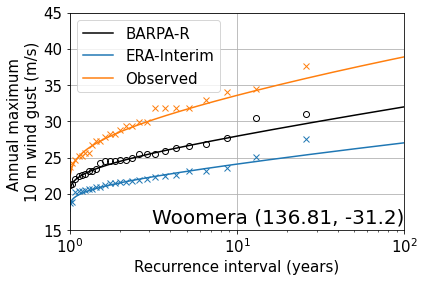

In [16]:
def compare_with_obs(loc_name, leg=False):

    stn_lon = df[df.stn_name==loc_name]["lon"]
    stn_lat = df[df.stn_name==loc_name]["lat"]
    
    #BARRA
    topog = xr.open_dataset("/g/data/du7/barpa/trials/BARPA-EASTAUS_12km/static/topog-BARPA-EASTAUS_12km.nc")["topog"].interp({"latitude":barpa_gev.lat, "longitude":barpa_gev.lon}, "nearest")
    lsm_barp = ((topog.values) > 0) * 1
    a,b = np.meshgrid(barpa_gev.lon, barpa_gev.lat)
    a[lsm_barp==0] = np.nan
    b[lsm_barp==0] = np.nan
    dist = np.sqrt(np.square(a-stn_lon.values[0]) + \
                        np.square(b-stn_lat.values[0]))
    temp_lat,temp_lon = np.unravel_index(np.nanargmin(dist),dist.shape)

    
    c = barpa_gev["c"].isel({"lat":temp_lat, "lon":temp_lon})
    loc = barpa_gev["loc"].isel({"lat":temp_lat, "lon":temp_lon})
    scale = barpa_gev["scale"].isel({"lat":temp_lat, "lon":temp_lon})
    p = np.linspace(0,1,10000)
    barp_T = 1/(1-p)
    barp_x = np.squeeze(genextreme.isf(q=1-p, c=c, loc=loc, scale=scale))
    barp_x_raw = np.sort(xr.open_dataset("/g/data/eg3/ab4502/gev/barpa_erai_annmax_annual_1990_2015.nc")["da"].isel({"lat":temp_lat, "lon":temp_lon}).values)
    barp_T_raw = (1 / (1 - ECDF(barp_x_raw).y))

    #ERAI
    topog = xr.open_dataset("/g/data/eg3/ab4502/erai_lsm.nc")["lsm"].interp({"latitude":erai_gev.lat, "longitude":erai_gev.lon}, "nearest")
    lsm_erai = (np.squeeze(topog.values) > 0) * 1
    a,b = np.meshgrid(erai_gev.lon, erai_gev.lat)
    a[lsm_erai==0] = np.nan
    b[lsm_erai==0] = np.nan
    dist = np.sqrt(np.square(a-stn_lon.values[0]) + \
                        np.square(b-stn_lat.values[0]))
    temp_lat,temp_lon = np.unravel_index(np.nanargmin(dist),dist.shape)

    c = erai_gev["c"].isel({"lat":temp_lat, "lon":temp_lon})
    loc = erai_gev["loc"].isel({"lat":temp_lat, "lon":temp_lon})
    scale = erai_gev["scale"].isel({"lat":temp_lat, "lon":temp_lon})
    p = np.linspace(0,1,10000)
    erai_T = 1/(1-p)
    erai_x = np.squeeze(genextreme.isf(q=1-p, c=c, loc=loc, scale=scale))
    erai_x_raw = np.sort(xr.open_dataset("/g/data/eg3/ab4502/gev/erai_annmax_annual_1990_2015.nc")["da"].isel({"lat":temp_lat, "lon":temp_lon}).values)
    erai_T_raw = (1 / (1 - ECDF(erai_x_raw).y))

    #OBS
    obs_x = np.sort(obs[obs.stn_name==loc_name].query("year>=1990").query("year<=2015")[["daily_date_lt", "wind_gust"]].iloc[:-1].resample("1Y", on="daily_date_lt").max()["wind_gust"].values)
    obs_T = (1 / (1 - ECDF(obs_x).y))
    c,loc,scale = genextreme.fit(obs_x)
    p = np.linspace(0,1,10000)
    obs_fit_x = genextreme.isf(q=1-p, c=c, loc=loc, scale=scale)
    obs_fit_T = 1/(1-p)

    plt.plot(barp_T, barp_x, label="BARPA-R", color="k")
    plt.plot(barp_T_raw[:-1], barp_x_raw, marker="o", linestyle="none", color="k", mfc="none")
    plt.plot(erai_T, erai_x, label="ERA-Interim", color="tab:blue")
    plt.plot(erai_T_raw[:-1], erai_x_raw, marker="x", linestyle="none", color="tab:blue")

    plt.plot(obs_fit_T, obs_fit_x, label="Observed", color="tab:orange")
    plt.plot(obs_T[:-1], obs_x, marker="x", color="tab:orange", linestyle="none")
    plt.ylim([15,45])
    plt.xlim([1,100])
    plt.xscale("log")
    #plt.title(loc_name, size=16)
    if leg:
        plt.legend(fontsize=15, loc=2)
    ax=plt.gca()
    ax.tick_params(axis='both', which='major', labelsize=15)
    plt.xlabel("Recurrence interval (years)", size=15)
    plt.ylabel("Annual maximum \n10 m wind gust (m/s)", size=15)

compare_with_obs("Woomera", True);plt.gca().grid();plt.text(100,16,"Woomera (136.81, -31.2)",size=20, ha="right")

plt.savefig("/g/data/eg3/ab4502/figs/barpa/return_period.png",bbox_inches="tight")


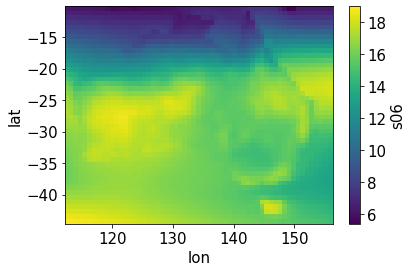

In [85]:
ll /g/data/eg3/ab4502/gev/barra_ann